In [1]:
%load_ext autoreload

In [351]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
from gpt.model import ViT, LightningMAE, MAE, LightningWrapper
from gpt.data import MNISTDataModule, CIFAR10DataModule, AddGaussianNoise
from gpt.utils import unpatchify
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
from tqdm.auto import tqdm
from einops import rearrange
import matplotlib

In [408]:
model = LightningMAE.load_from_checkpoint('../train/lightning_logs/version_1030931/checkpoints/epoch=18-step=4465.ckpt', map_location='cuda:1')

/scratch/gpfs/js5013/.conda/envs/foundation/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'vit' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vit'])`.


In [409]:
def collate(lop):
    x, _ = zip(*lop)
    x = torch.stack(x)
    return x
mnist = MNISTDataModule(root_dir='/scratch/gpfs/js5013/data/ml/', num_workers=4, batch_size=32, collate_fn=collate)
mnist.setup()
tl = mnist.train_dataloader()

In [80]:
x = next(iter(tl))

In [81]:
def show(imgs, ncols=None, **kwargs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs) if ncols is None else ncols, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), **kwargs)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

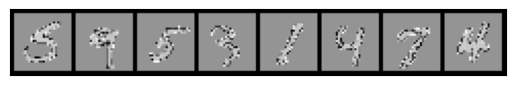

In [82]:
show(torchvision.utils.make_grid(x))

In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
bix = torch.arange(32, dtype=int).unsqueeze(-1)

for x in (pbar := tqdm(tl)):
    optimizer.zero_grad()
    mp, omp, mask_idx = model(x.to('cuda:1'))
    
    loss = F.mse_loss(mp[bix, mask_idx], omp[bix, mask_idx])
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()
    pbar.set_description(f"loss: {loss.item():.3f}")

  0%|          | 0/1875 [00:00<?, ?it/s]

In [337]:
tll = mnist.test_dataloader()

In [359]:
x = next(iter(tll))

with torch.no_grad():
    mp, omp, mask_idx = model(x.to('cuda:1'))

In [428]:
p2i = lambda x: mnist.unnormalize(x)[0]

In [425]:
ix = 6
oo = omp[ix].detach().cpu()
img_true = unpatchify(mp[ix].detach().cpu(), 1)
img = unpatchify(oo, 1)

In [426]:
img_masked = mp[ix].detach().clone()
img_masked[mask_idx[ix]] = torch.nan
img_masked = unpatchify(img_masked, 1)

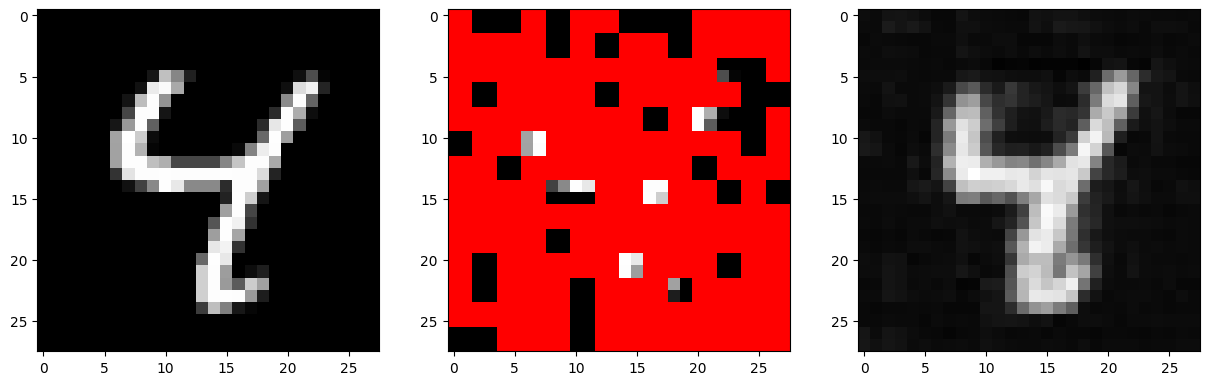

In [429]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
cmap = matplotlib.cm.gray
cmap.set_bad('red',1.)
ax[0].imshow(p2i(img_true), cmap=cmap)
ax[1].imshow(p2i(img_masked.detach().cpu()), cmap=cmap)
ax[2].imshow(p2i(img), cmap=cmap)

In [375]:
cifar = CIFAR10DataModule(batch_size=64)

In [176]:
cifar.setup()

In [177]:
tl = cifar.test_dataloader()

In [178]:
x, y = next(iter(tl))

In [307]:
with torch.no_grad():
    mp, omp, mask_idx = model(x.to('cuda:1'))

In [308]:
p2i = lambda x: TF.to_pil_image(cifar.unnormalize(x))

In [333]:
ix = 27
oo = omp[ix].detach().cpu()
img_true = unpatchify(mp[ix].detach().cpu(), 3)
img = unpatchify(oo, 3)

In [334]:
img_masked = mp[ix].detach().clone()
img_masked[mask_idx[ix]] = torch.nan
img_masked = unpatchify(img_masked, 3)

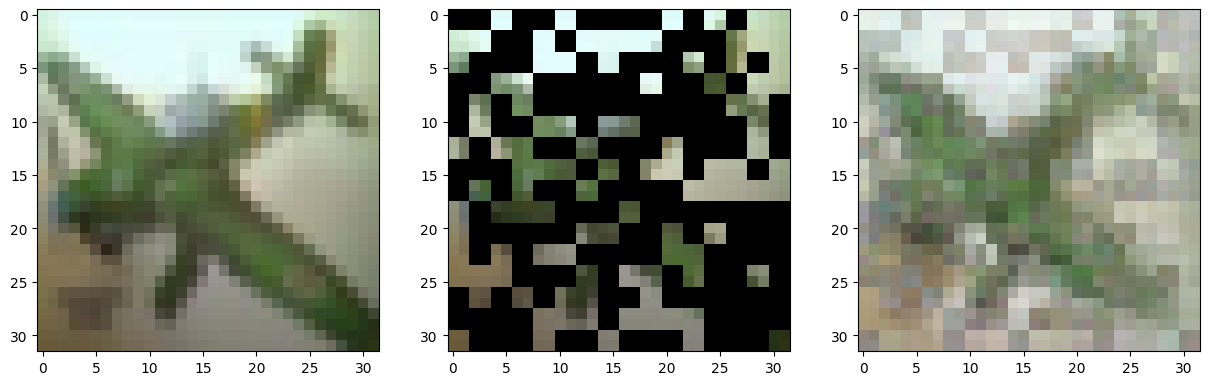

In [335]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(p2i(img_true))
ax[1].imshow(p2i(img_masked))
ax[2].imshow(p2i(img))